Uniqness analysis
===============

In this document we will analyze whether the number of uniq kmers in the genes affect the precision and recall performance of `shark`.

## Data description

### Input data
We considered the 9403 genes from chromosomes 1, 17, and 21 of the Human Genome and we simulated a RNA-Seq sample of 10M 100-bp long reads using Flux Simulator.

### Shark parameters
We ran `shark` using the 10M reads as input and providing the annotation of all the 9403 genes.
`shark` was ran in both *single* and *multi* mode.
We recall that in single mode `shark` discard a read if it is assigned to multiple genes with the same score, whereas in multi mode both assignements are produced as output.

We ran `shark` setting the kmer size to 13, 17, and 31 (see later for the motivation).

### Uniqness index
We designed two measures of uniqness: UIPT (Uniq Index Per Transcripts) and UIPG (Uniq Index Per Gene region).
Both measures depend on the kmer size and are defined as follow.

Let $g$ be a gene of the gene pool and let $t$ be the set of annotated transcripts of $g$, we define $GK_s(g)$ as the set of of $s$-mers appearing in the gene region of $g$, and $TK_s(g)$ as the set of $s$-mers appearing in all the transcripts of $g$.

Moreover, we define $GK_s$ as the union of all $GK_s(g)$ over all the genes of the gene pool, and $TK_s$ as the union of all the $TK_s(g)$ over the same pool.

Let $g$ be a gene of the gene pool and let $s$ be a kmer-size, we define $UIPG_s(g)$ as $\frac{\vert (GK_s(g) \setminus GK_s) \vert}{\vert GK_s(g) \vert}$, i.e., $GK_s(g)$ is the fraction of $s$-mers of the gene region of $g$ that appear only in that gene region over the number of $s$-mer of the gene region.

Similarly, we define $UIPT_s(g)$ as $\frac{\vert (TK_s(g) \setminus TK_s) \vert}{\vert TK_s(g) \vert}$, i.e., $TK_s(g)$ is the fraction of $s$-mers of the annotated transcripts of $g$ that appear only in the transcripts of $g$ over the number of $s$-mer of the annotated transcripts.

The two indexes are similar but represent slightly different measures.
Indeed, UIPG considers as kmers of the gene all the kmers appearing in the gene region, thus considering kmers in the introns but not considering kmers overlapping splicing sites.
Instead, UIPT considers as kmers of the gene all the kmers appearing in all the transcripts of the gene, thus considering the kmers overlapping splicing sites but not considering kmers in the introns.

We computed the uniqness indexes of each gene for kmer sizes 13, 17, 23, 27, and 31 and we will now analyze how they are distributed over the set of 9403 genes.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import display, HTML, display_html, Markdown

kmer_lens = (13, 17, 23, 27, 31)
modes = ("single", "multi")

In [2]:
# Support function
def bins_limits(low, high, n=25):
    r = high - low
    bin_size = r / n
    return [low + bin_size * i for i in range(1, n+1)]

UIPG was precomputed all the kmer sizes and is stored in files `UIPG/[l].uniq_idx.tsv` where `l` is the length of the kmer.

UIPT was precomputed all the kmer sizes and is stored in files `UIPT/[l].gene.uniq_idx.tsv` where `l` is the length of the kmer.

Each line in the file reports the gene name, the number of uniq kmers, the total number of kmers, and the uniqness index.
Each value is separated by a TAB char.

Let's load these values in memory, we will use them later on to check whether they affect the perfomance of `shark`.

In [4]:
UIPT = {}
UIPG = {}

for l in kmer_lens:
    UIPT[l] = pd.read_csv(f"UIPT/{l}.uniq_idx.tsv",
                          sep='\t',
                          header=None,
                          names=["gene", "uniq kmers", "total kmers", "UIPT"],
                          index_col=0)    
    UIPG[l] = pd.read_csv(f"UIPG/{l}.gene.uniq_idx.tsv",
                          sep='\t',
                          header=None,
                          names=["gene", "uniq kmers", "total kmers", "UIPG"],
                          index_col=0)

Before diving into analyzing UIPG and UIPT, let's check the distribution of distinct and uniq kmers in the genes of the gene panel.

## Distribution of distinct kmers in genes and in transcripts

We recall that the number of distinct kmers is the number of kmers appearing in each gene region or in all the transcripts of a gene.

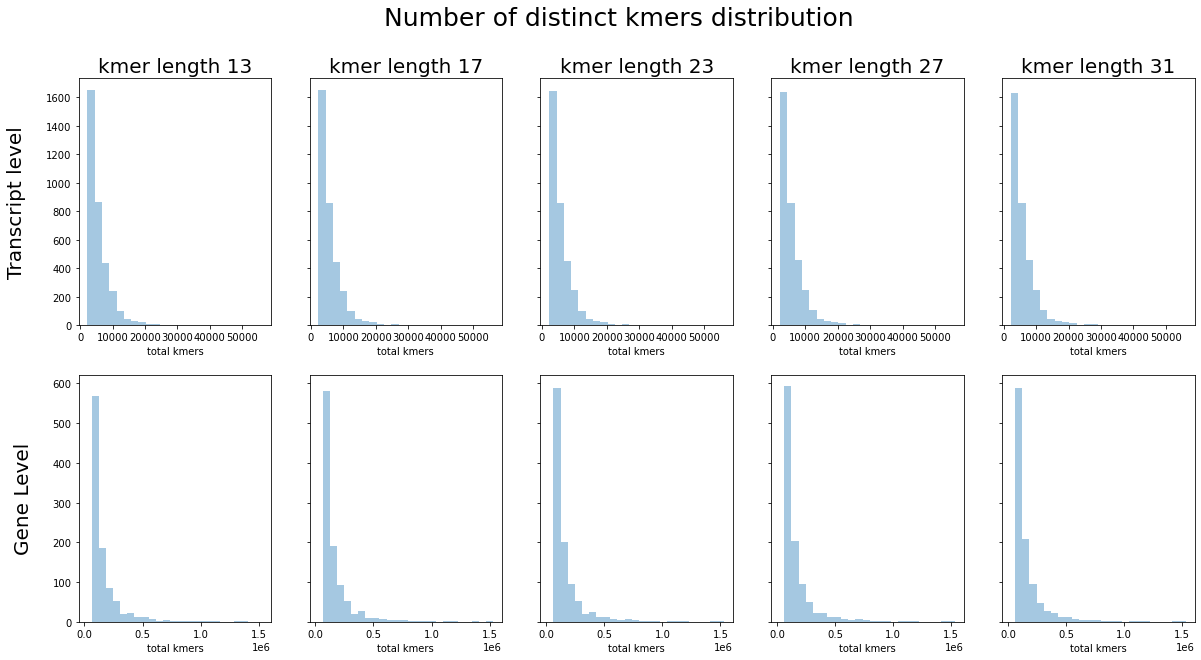

In [7]:
fig, big_axs = plt.subplots(2, 5,
                            sharey="row",
                            sharex="row",
                            figsize=[20,10]);

fig.suptitle("Number of distinct kmers distribution", fontsize=25);
big_axs[0][0].set_ylabel("Transcript level", fontsize=20, labelpad=20);
big_axs[1][0].set_ylabel("Gene Level", fontsize=20, labelpad=20);

mkpt = max((pd.to_numeric(UIPT[l]["total kmers"], errors="coerce").max() for l in kmer_lens))
mkpg = max((pd.to_numeric(UIPG[l]["total kmers"], errors="coerce").max() for l in kmer_lens))

for i, l in enumerate(kmer_lens):
    sns.distplot(pd.to_numeric(UIPT[l]["total kmers"], errors="coerce"),
                 bins=bins_limits(0, mkpt),
                 ax=big_axs[0][i],
                 kde=False);
    big_axs[0][i].set_title(f"kmer length {l}", fontsize=20);
    sns.distplot(pd.to_numeric(UIPG[l]["total kmers"], errors="coerce"),
                 bins=bins_limits(0, mkpg),
                 ax=big_axs[1][i],
                 kde=False);
plt.show();

Although the distributions shown in the previous graphs are similar in shape, please note that the maximum number of distinct genes greatly varies if computed on transcripts or on gene regions (as expected).

## Distribution of uniq kmers in genes and in transcripts

We recall that the number of uniq kmers is the number of kmers appearing only in one gene region or only in the transcripts of a single gene.

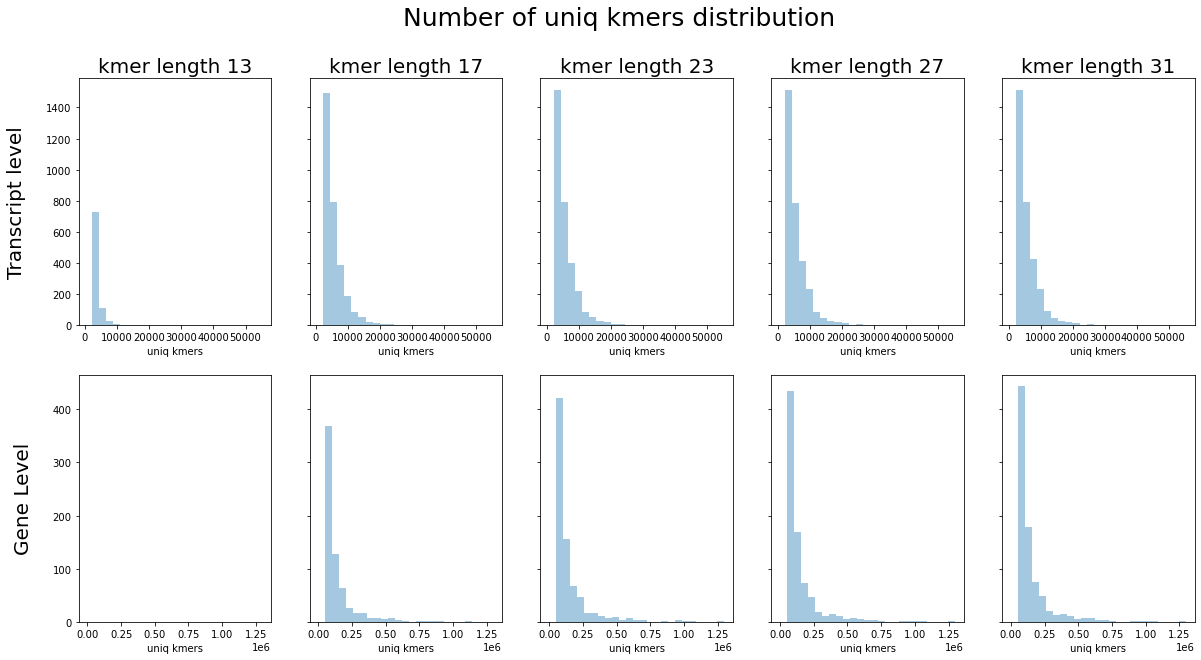

In [8]:
fig, big_axs = plt.subplots(2, 5,
                            sharey="row",
                            sharex="row",
                            figsize=[20,10]);

fig.suptitle("Number of uniq kmers distribution", fontsize=25);
big_axs[0][0].set_ylabel("Transcript level", fontsize=20, labelpad=20);
big_axs[1][0].set_ylabel("Gene Level", fontsize=20, labelpad=20);

mkpt = max((pd.to_numeric(UIPT[l]["uniq kmers"], errors="coerce").max() for l in kmer_lens))
mkpg = max((pd.to_numeric(UIPG[l]["uniq kmers"], errors="coerce").max() for l in kmer_lens))

for i, l in enumerate(kmer_lens):
    sns.distplot(pd.to_numeric(UIPT[l]["uniq kmers"], errors="coerce"),
                 bins=bins_limits(0, mkpt),
                 ax=big_axs[0][i],
                 kde=False);
    big_axs[0][i].set_title(f"kmer length {l}", fontsize=20);
    sns.distplot(pd.to_numeric(UIPG[l]["uniq kmers"], errors="coerce"),
                 bins=bins_limits(0, mkpg),
                 ax=big_axs[1][i],
                 kde=False);
plt.show();

We note that the distribution of uniq kmers is similar to the distribution of distinct kmers (scaled down) and that almost no 13-mer is uniq at gene level.

## Distribution of uniqness indexes

Let's now analyze the distribution of UIPT and UIPG

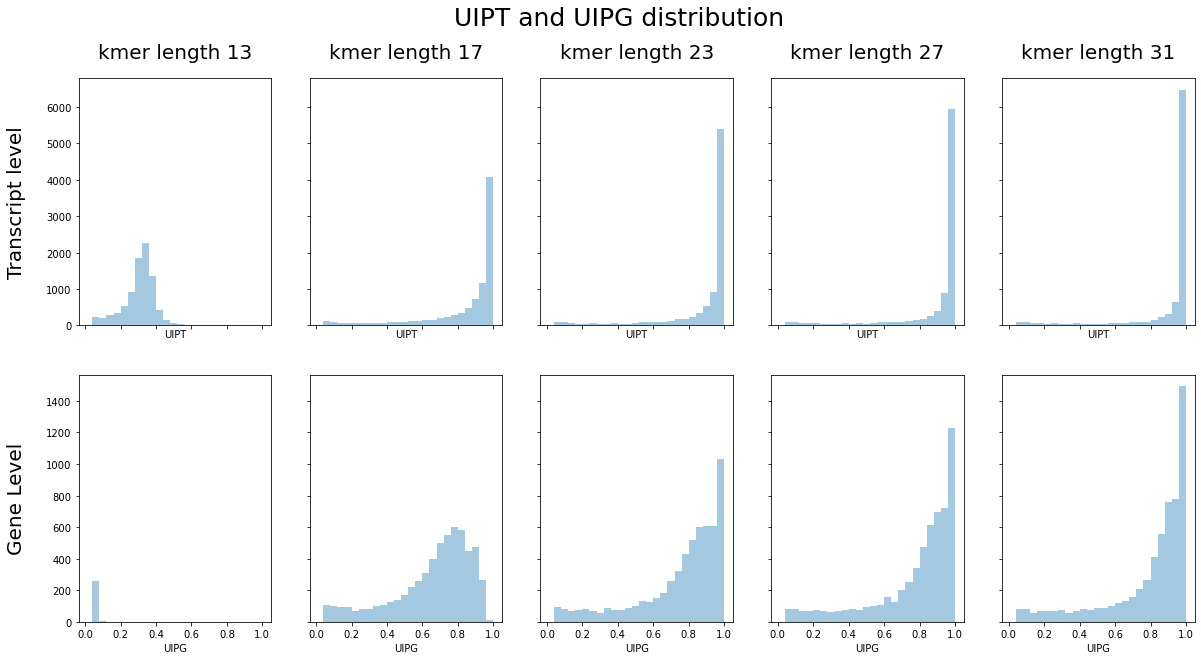

In [9]:
fig, big_axs = plt.subplots(2, 5,
                            sharex=True,
                            sharey="row",
                            figsize=[20,10]);

fig.suptitle("UIPT and UIPG distribution", fontsize=25);
big_axs[0][0].set_ylabel("Transcript level", fontsize=20, labelpad=20);
big_axs[1][0].set_ylabel("Gene Level", fontsize=20, labelpad=20);

mkpt = max((pd.to_numeric(UIPT[l]["UIPT"], errors="coerce").max() for l in kmer_lens))
mkpg = max((pd.to_numeric(UIPG[l]["UIPG"], errors="coerce").max() for l in kmer_lens))

for i, l in enumerate(kmer_lens):
    sns.distplot(pd.to_numeric(UIPT[l]["UIPT"], errors="coerce"),
                 bins=bins_limits(0, mkpt),
                 ax=big_axs[0][i],
                 kde=False);
    big_axs[0][i].set_title(f"kmer length {l}", fontsize=20, pad=20);
    sns.distplot(pd.to_numeric(UIPG[l]["UIPG"], errors="coerce"),
                 bins=bins_limits(0, mkpg),
                 ax=big_axs[1][i],
                 kde=False);
plt.show();

These graphs show that UIPG and UIPT are quite different and that UIPG tends to be smaller than UIPT.
Moreover, the smaller the value of k, the more UIPG and UIPT are small.

Finally, we note thatfor kmer size equal to 23, 27 and 31 the distribution of UIPT is similar and that the same applies to UIPG.

## Shark precision and recall

As stated in the paper, the value of precision and recall of `shark` varies depending on the kmer size.
We ran `shark` on all 9403 genes for kmer size 13, 17, and 31 and both in single and multi mode.

Since the distribution of UIPG and UIPT for kmer sizes 23, 27, and 31 are similar on this dataset, we didn't run shark with kmer size 23 and 27 and use kmer size 31 as reference for all the 3 values.

Precision and recall on each gene values for kmer size `l` and mode `mode` are stored in file `PR_data/{mode}/k{l}.{mode}.PR_per_gene.tsv`.

Let's first load in memory these values.

In [10]:
pr = {}
pr_lengths = (13, 17, 31)

for m in modes:
    pr[m] = {}
    for l in pr_lengths:
        p = pd.read_csv(f"PR_data/{m}/k{l}.{m}.PR_per_gene.tsv", sep='\t', index_col=0)
        pr[m][l] = p

We now remove genes that have 0 TP, 0 FP, and 0 FN (thus undefined precision and recall) from the dataframe to avoid skewing the analysis.

Note that the number of rows removed by each dataframe is different since the number of TP varies depending on the value of k.

In [11]:
for m in modes:
    for l in pr_lengths:
        fdf = pr[m][l]
        fdf = fdf[(fdf["TP"] != 0) | (fdf["FN"] != 0) | (fdf["FP"] != 0)]
        pr[m][l] = fdf
for m in modes:
    for l in pr_lengths:
        print(f"Entries for k={l} and mode={m}: {len(pr[m][l])}")

Entries for k=13 and mode=single: 6195
Entries for k=17 and mode=single: 6121
Entries for k=31 and mode=single: 6161
Entries for k=13 and mode=multi: 8463
Entries for k=17 and mode=multi: 8105
Entries for k=31 and mode=multi: 7733


Surprisingly, the number of entries increases with k in single mode, whereas it decreases for increasing k in multi mode.

Let's now visualize the precision and recall distribution depending on the mode and the kmer length.

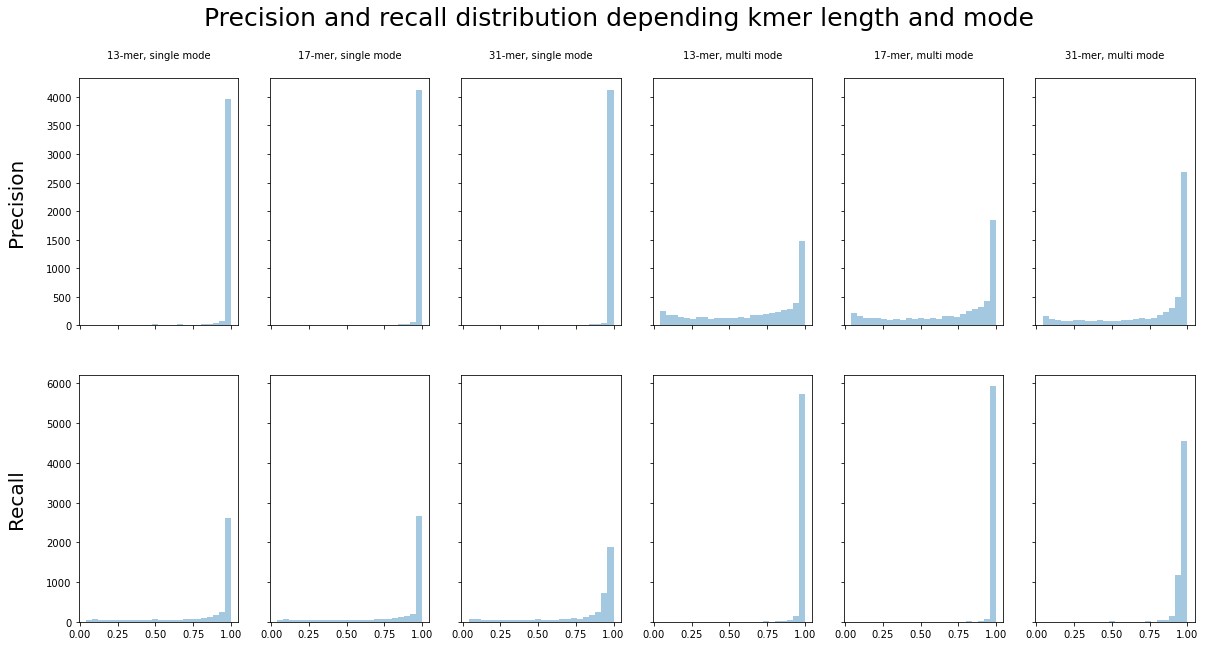

In [12]:
fig, big_axs = plt.subplots(2, 6,
                            sharey="row",
                            sharex=True,
                            figsize=[20,10]);

fig.suptitle("Precision and recall distribution depending kmer length and mode", fontsize=25);
big_axs[0][0].set_ylabel("Precision", fontsize=20, labelpad=20);
big_axs[1][0].set_ylabel("Recall", fontsize=20, labelpad=20);

for i, m in enumerate(modes):
    for j, l in enumerate(pr_lengths):
        sns.distplot(pr[m][l]['P'], bins=bins_limits(0, 1.0),
                     ax=big_axs[0][i*3 + j],
                     axlabel=False,
                     kde=False);
        sns.distplot(pr[m][l]['R'], bins=bins_limits(0, 1.0),
                     ax=big_axs[1][i*3 + j],
                     axlabel=False,
                     kde=False);
        big_axs[0][i*3 + j].set_title(f"{l}-mer, {m} mode", fontsize=10, pad=20);
plt.show();

As reported in the main manuscript, these graphs show that single mode has higher precision whereas multi mode has higher recall.

Moreover, increasing the value of k increases the precision of the tool but decreases its recall.

# UIPG analysis

We now analyze whether the value of UIPG affect the precision and recall of `shark`.

First, we split the genes into 3 classes based on their value of UIPG (low UIPG, medium UIPG, and high UIPG).
A gene is assigned to a class as follows:
* if UIPG is smaller or equal to 0.10 then the class is low UIPG
* if UIPG is greater or equal to 0.90 then the class is high UIPG
* otherwise the class i medium UIPG

Note that we will perform the same analysis for both modes and for all the kmer sizes.

In [13]:
# First we join the precision and recall dataframes with
# the dataframe that includes UIPG
uipg_groups = {}

UIPG_labels = ["low UIPG", "medium UIPG", "high UIPG"]

for m in modes:
    uipg_groups[m] = {}
    for l in pr_lengths:
        pr_uipg_df = pr[m][l].join(UIPG[l])
        uipg_groups[m][l] = pr_uipg_df.groupby(pd.cut(pr_uipg_df["UIPG"],
                                                      bins=(0, 0.10, 0.90, 1.0),
                                                      labels=UIPG_labels))

Let's now take a look at how many genes are in each group.

In [14]:
_d = {(m, k, t) : uipg_groups[m][k].size()[t] for k in pr_lengths \
                                              for m in modes \
                                              for t in uipg_groups[m][l].groups.keys()}
_uipg_df_cnts =  \
      pd.DataFrame(_d.values(), index=pd.MultiIndex.from_tuples(_d.keys()))[0] \
                .unstack()[UIPG_labels] \
                .style \
                .set_caption("Genes distribution by kmer size and UIPG level")
display(_uipg_df_cnts)

As we can see from the previous table, the higher the kmer size is the more genes fall in higher UIPG classes.
Let's now look at average precision and recall values in each class for each mode and for each kmer size.

Note that there are no elements in the high UIPG class for kmer size equal to 13.

In [15]:
_dp = {(m, k, t) : uipg_groups[m][k].P.mean()[t] for k in pr_lengths \
                                                 for m in modes \
                                                 for t in uipg_groups[m][l].groups.keys()}
_uipg_df_p =  \
      pd.DataFrame(_dp.values(), index=pd.MultiIndex.from_tuples(_dp.keys()))[0].unstack()[UIPG_labels] \
           .style \
           .set_caption("Precision")

_dr = {(m, k, t) : uipg_groups[m][k].R.mean()[t] for k in pr_lengths \
                                                 for m in modes \
                                                 for t in uipg_groups[m][l].groups.keys()}
_uipg_df_r =  \
      pd.DataFrame(_dr.values(), index=pd.MultiIndex.from_tuples(_dr.keys()))[0].unstack()[UIPG_labels] \
           .style \
           .set_caption("Recall")

display(_uipg_df_p)
display(_uipg_df_r)

By looking at the average value in the classes, it seems that whathever the mode and the kmer size are, the higher the value of UIPG is the higher precision and recall are.

We also note that, in in most cases precision and recall decrease for increasing values of kmer size in the same class.

Although this seems to make sense, the average of precision and recall do not show the full picture.
We will now plot the values of precision and recall of all the genes, splitting the points by kmer sizes and UIPG class.

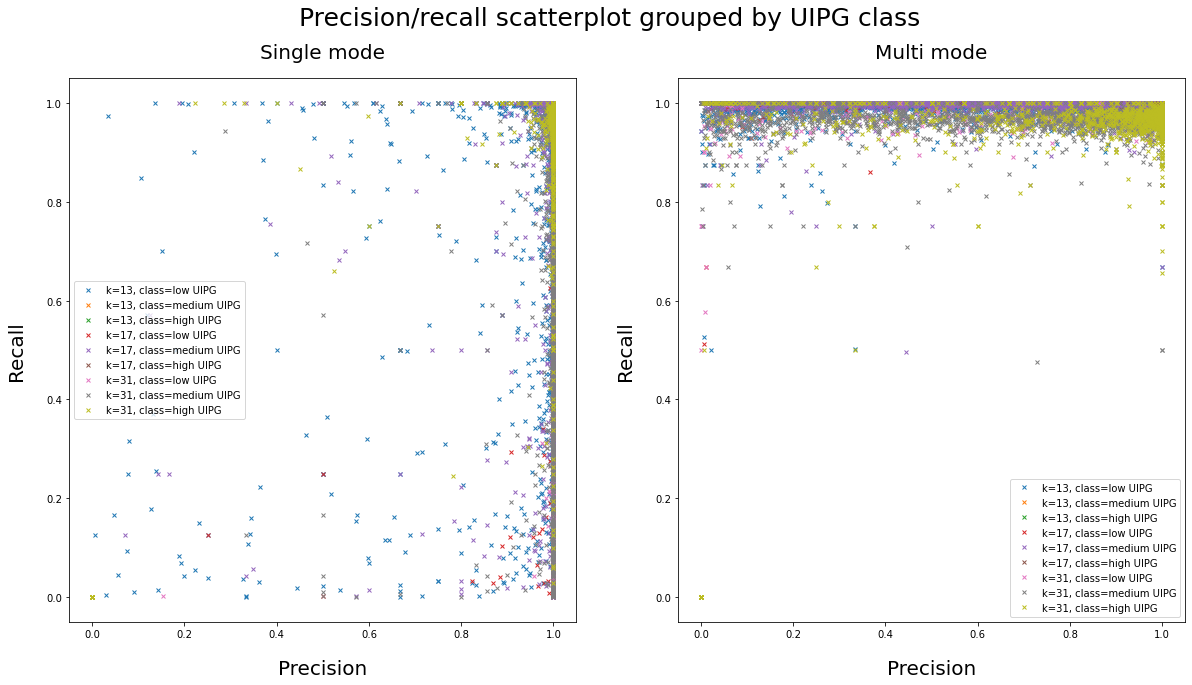

In [16]:
fig, axs = plt.subplots(1, 2, figsize=[20, 10])

fig.suptitle("Precision/recall scatterplot grouped by UIPG class", fontsize=25);
axs[0].set_xlabel("Precision", fontsize=20, labelpad=20);
axs[0].set_ylabel("Recall", fontsize=20, labelpad=20);
axs[0].set_title("Single mode", fontsize=20, pad=20)

axs[1].set_xlabel("Precision", fontsize=20, labelpad=20);
axs[1].set_ylabel("Recall", fontsize=20, labelpad=20);
axs[1].set_title("Multi mode", fontsize=20, pad=20)

for l in pr_lengths:
    for i, m in enumerate(modes):
        for name, group in uipg_groups[m][l]:
            axs[i].plot(group.P, group.R, marker='x', linestyle='', ms=4, label=f"k={l}, class={name}")
axs[0].legend()
axs[1].legend()
plt.show()

This graph clearly shows that the average of precision and recall does not show the whole picture.
Indeed, although higher kmer sizes and higher UIPG classes improve the results of precision and recall, the variability of precision and recall in the same class is extremely high.

# UIPT analysis

Similarly to the previous section, 
we now analyze whether the value of UIPT affect the precision and recall of `shark`.

First, we split the genes into 3 classes based on their value of UIPT (low UIPT, medium UIPT, and high UIPT).
A gene is assigned to a class as follows:
* if UIPT is smaller or equal to 0.10 then the class is low UIPT
* if UIPT is greater or equal to 0.90 then the class is high UIPT
* otherwise the class i medium UIPT

Note that we will perform the same analysis for both modes and for all the kmer sizes.

In [17]:
# First we join the precision and recall dataframes with
# the dataframe that includes UIPT
uipt_groups = {}

UIPT_labels = ["low UIPT", "medium UIPT", "high UIPT"]

for m in modes:
    uipt_groups[m] = {}
    for l in pr_lengths:
        pr_uipt_df = pr[m][l].join(UIPT[l])
        uipt_groups[m][l] = pr_uipt_df.groupby(pd.cut(pd.to_numeric(pr_uipt_df["UIPT"], errors="coerce"),
                                                      bins=(0, 0.10, 0.90, 1.0),
                                                      labels=UIPT_labels))

Again let's look at how many elements are in each group.

In [18]:
_d = {(m, k, t) : uipt_groups[m][k].size()[t] for k in pr_lengths \
                                              for m in modes \
                                              for t in uipt_groups[m][l].groups.keys()}
_uipt_df_cnts =  \
      pd.DataFrame(_d.values(), index=pd.MultiIndex.from_tuples(_d.keys()))[0] \
            .unstack()[UIPT_labels] \
            .style \
            .set_caption("Genes distribution by kmer size and UPT level")
display(_uipt_df_cnts)

And print the precision and recall values of each group.

In [20]:
_dp = {(m, k, t) : uipt_groups[m][k].P.mean()[t] for k in pr_lengths \
                                                 for m in modes \
                                                 for t in uipt_groups[m][l].groups.keys()}
_uipt_df_p =  \
      pd.DataFrame(_dp.values(), index=pd.MultiIndex.from_tuples(_dp.keys()))[0].unstack()[UIPT_labels] \
           .style \
           .set_caption("Precision")

_dr = {(m, k, t) : uipt_groups[m][k].R.mean()[t] for k in pr_lengths \
                                                 for m in modes \
                                                 for t in uipt_groups[m][l].groups.keys()}
_uipt_df_r =  \
      pd.DataFrame(_dr.values(), index=pd.MultiIndex.from_tuples(_dr.keys()))[0].unstack()[UIPT_labels] \
           .style \
           .set_caption("Recall")

display(_uipt_df_p)
display(_uipt_df_r)

As per UIPG, by looking at the average value in the classes, it seems that whathever the mode and the kmer size are, the higher the value of UIPG is the higher precision and recall are.

We also note that, in in most cases precision and recall decrease for increasing values of kmer size in the same class.

Similarly to before, the average of precision and recall do not show the full picture.
Thus, we will now plot the values of precision and recall of all the genes, splitting the points by kmer sizes and UIPG class.

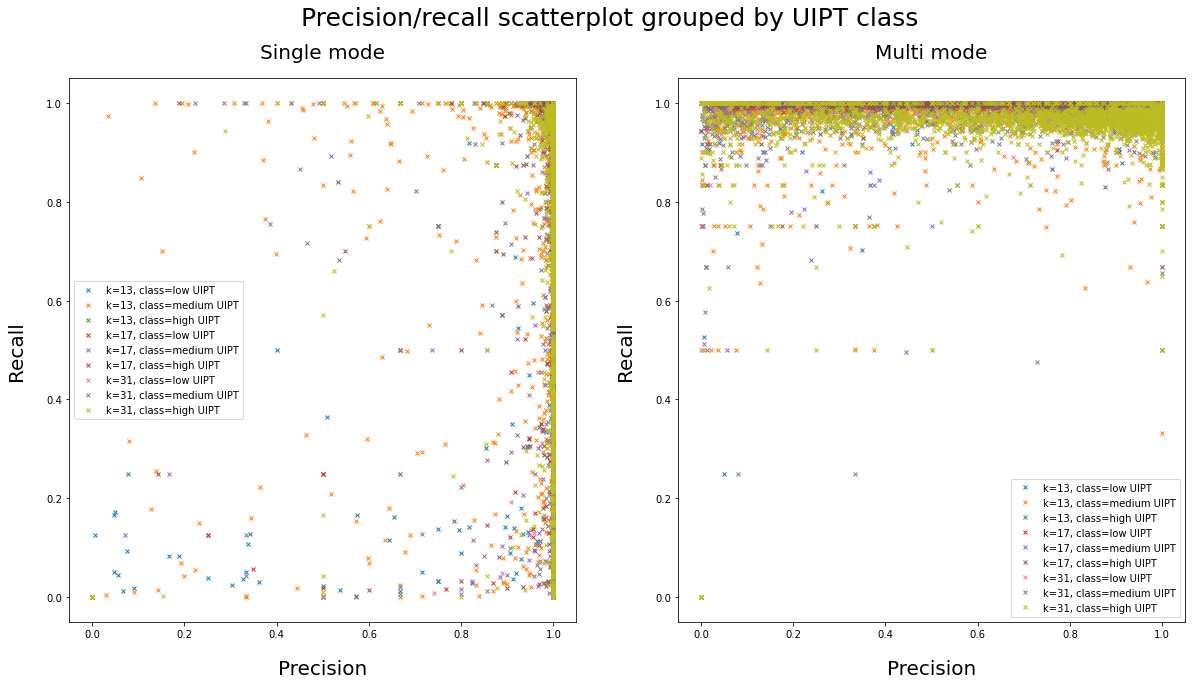

In [21]:
fig, axs = plt.subplots(1, 2, figsize=[20, 10])

fig.suptitle("Precision/recall scatterplot grouped by UIPT class", fontsize=25);
axs[0].set_xlabel("Precision", fontsize=20, labelpad=20);
axs[0].set_ylabel("Recall", fontsize=20, labelpad=20);
axs[0].set_title("Single mode", fontsize=20, pad=20)

axs[1].set_xlabel("Precision", fontsize=20, labelpad=20);
axs[1].set_ylabel("Recall", fontsize=20, labelpad=20);
axs[1].set_title("Multi mode", fontsize=20, pad=20)

for l in pr_lengths:
    for i, m in enumerate(modes):
        for name, group in uipt_groups[m][l]:
            axs[i].plot(group.P, group.R, marker='x', linestyle='', ms=4, label=f"k={l}, class={name}")
axs[0].legend()
axs[1].legend()
plt.show()

From this graphs you can see that there is almost no relation between UIPT and the values of precision and recall.

If we compare them with the ones based on UIPG, we can see that in this case the distributions are even worse.

# Conclusions

We analyzed whether simple uniqness indexes based on the kmer spectrum of the gene regions and of the transcripts relates to the precision and recall of `shark` and found no strong evidence to sustain this claim.

To better understand why this happen we report an example that contradicts such theory.
We focus on genes SLC5A10 (Ensembl ID ENSG00000154025) and gene FAM83G (Ensembl ID ENSG00000188522).
These two genes are on the same region of Human Chromosome 17 but on different strands (SLC5A10 is on the forward strand whereas FAM83G is on the reverse strand).
Moreover, FAM83G is completely included in SLC5A10 (see the following image).

![img](img/genes.png)

Let's now look at UIPG and UIPT values of these two genes.

| Gene | k | UIPG | UIPT|
|------|---|------|------|
| FAM83G | 13 | 0.0 | 0.3100715746421268 |
| FAM83G | 17 | 0.0 | 0.9559892843474933 |
| FAM83G | 31 | 0.0 | 0.9865036923860453 |
| SLC5A10 | 13 | 0.00827448462800485 | 0.311080203987019 |
| SLC5A10 | 17 | 0.34061912906934355 | 0.9934018720270062 |
| SLC5A10 | 31 | 0.40547225868859255 | 0.9950987900137847 |

Clearly since FAM83G region is a subregion of SLC5A10 its UIPG is 0 whereas its UIPT varies between 0.31 and 0.98 since the two genes have almost no introns in common.

Let's now count the TP and FP assignments of `shark` to these two genes.
Clearly, we expect that the reads extracted from FAM83G will be assigned to SLC5A10 and that some of the reads extracted from SLC5A10 will be assigned to FAM83G since the two genes are overlapping.

| Gene | k | mode | TP | FP | FN | P | R |
|-|-|-|-|-|-|-|-|
|SLC5A10| 13 | single | 1143|102|761|0.918|0.6 |
|SLC5A10| 17 | single | 1126|2|778|0.998|0.591 |
|SLC5A10| 31 | single | 1053|0|851|1.0|0.553 |
|SLC5A10| 13 | multi |  1897|27102|7|0.065|0.996 |
|SLC5A10| 17 | multi | 1898|26945|6|0.066|0.997 |
|SLC5A10| 31 | multi | 1833|26196|71|0.065|0.963 |
| FAM83G | 13 | single |0|0|19764|0|0.0 |
| FAM83G | 17 | single |0|0|19764|0|0.0 |
| FAM83G | 31 | single |0|0|19764|0|0.0 |
| FAM83G | 13 | multi |19664|710|100|0.965|0.995 |
| FAM83G | 17 | multi |19715|641|49|0.969|0.998 |
| FAM83G | 131 | multi |19359|538|405|0.973|0.98 |

From this table, we can see that, as expected, in single mode no read is assigned to FAM83G since they are assigned to SLC5A10 too, thus precision and recall are 0.
On the other hand, in multi mode FAM83G provides good precision and recall but SLC5A10 has an extremely low precision.

We may ask ourselves "why so"?  The reason is that FAM83G is way more expressed than SLC5A10 (indeed the first has ~19500 reads correctly assigned to it in multi mode, wherheas the second one only has ~1800).  Thus, since in multi mode all the reads of FAM83G are assiged to SLC5A10 too, SLC5A10 will have a high number of FP assignment, drastically reducing the precision.

In conclusion, simple uniqness indexes cannot completely relate to precision and recall performance of `shark` since the expression level of each gene affect the number of TP and FP.